In [39]:
import sklearn
from sklearn.datasets import load_digits
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set_theme(style='white')

### Task 1

In [40]:
digits = load_digits()
print (digits.keys())
data = digits["data"]
images = digits["images"]
target = digits["target"]
target_names = digits["target_names"]

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])


In [41]:
threes = np.array([images[i] for i in range (len(images)) if target[i] == 3])
nines = np.array([images[i] for i in range (len(images)) if target[i] == 9])

print(threes.shape)
print(nines.shape)

(183, 8, 8)
(180, 8, 8)


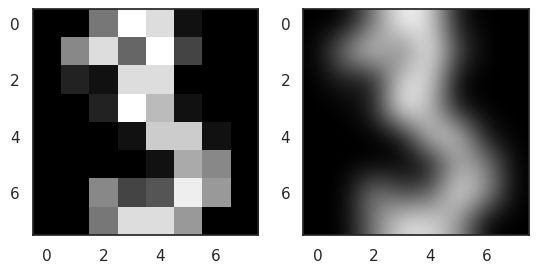

In [42]:
img = threes[0]
assert 2 == len(img.shape)

## plot image side by side with neareste and bicubic interpolation
plt.figure()
plt.gray()
plt.subplot(1,2,1)
plt.imshow(img, interpolation="nearest" )
plt.subplot(1,2,2)
plt.imshow(img, interpolation="bicubic" ) 
plt.show()

In [43]:
from sklearn import model_selection

filter_indices = np.where((digits.target == 3) | (digits.target == 9))[0]
filtered_data = digits.data[filter_indices]
filtered_target = digits.target[filter_indices]

X_train, X_test, y_train, y_test = model_selection.train_test_split(filtered_data, filtered_target, test_size=0.4,random_state=0)

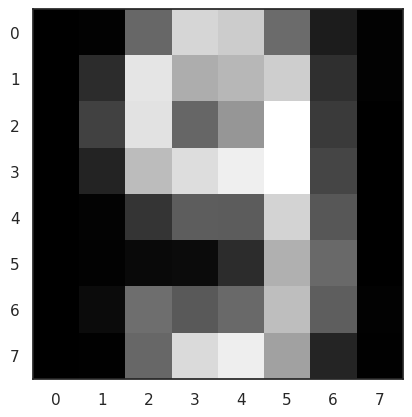

In [44]:
## explore mean image of 9s
mean_nine = np.mean(nines, axis=0)
plt.figure()
plt.gray()
plt.imshow(mean_nine,interpolation="nearest")

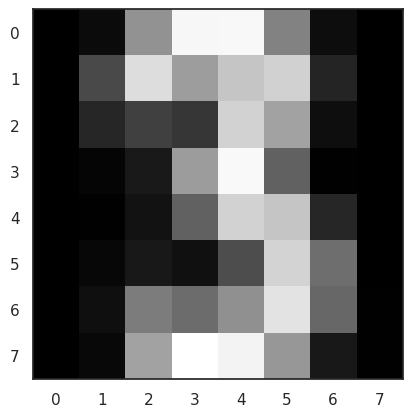

In [45]:
## explore mean image of 3s
threes_mean = np.mean(threes, axis=0)
# threes_mean[0,4] = 0 ## primu indice e pe oy, al doilea pe ox
plt.figure()
plt.gray()
plt.imshow(threes_mean,interpolation="nearest")

### Task 2

In [46]:
def features2d(x):
    '''
    candidate pixels: 
    
    (2,2) - bright in nine, dark in three
    (3,2) - bright in nine, dark in three
    (3,5) - bright in nine, gray in three - less
    (2,5) - bright in nine, gray in three - less 

    max value: 16
    min value: 0
    '''

    x_ = x.reshape(-1,8,8)
    
    f1 = 0.5*(x_[:,2,2] + x_[:,3,2]) ## [0,16]
    f2 = x_[:,3,5] + x_[:,2,5] ## [0,32]
    return np.column_stack((f1,f2))

def transform_labels(y):
    y[y == 3] = -1
    y[y == 9] = 1
    return y


def get_bisector(a,b):
    return (a + b)/np.linalg.norm(a + b)

def get_clusters(training_features,training_labels):
    mean_3 = np.mean(training_features[training_labels == -1],axis=0)
    mean_9 = np.mean(training_features[training_labels == 1],axis=0)

    return mean_3,mean_9

def error(labels,predicted_labels):
    return np.sum(labels != predicted_labels)/labels.shape[0]

def nearest_mean(training_features,training_labels,test_features):
    mean_3 = np.mean(training_features[training_labels == -1],axis=0)
    mean_9 = np.mean(training_features[training_labels == 1],axis=0)

    bisector = get_bisector(mean_3,mean_9)

    ## assign each test_feature to the closest mean
    test_labels = np.zeros(test_features.shape[0])
    predicted_train_lables = np.zeros(training_features.shape[0])
    for i in range(test_features.shape[0]):
        dist_3 = np.linalg.norm(test_features[i] - mean_3)
        dist_9 = np.linalg.norm(test_features[i] - mean_9)
        test_labels[i] = -1 if dist_3 < dist_9 else 1

    for i in range(training_features.shape[0]):
        dist_3 = np.linalg.norm(training_features[i] - mean_3)
        dist_9 = np.linalg.norm(training_features[i] - mean_9)
        predicted_train_lables[i] = -1 if dist_3 < dist_9 else 1

    print("Training error: ",error(training_labels,predicted_train_lables))

    
    return test_labels

(217, 2)


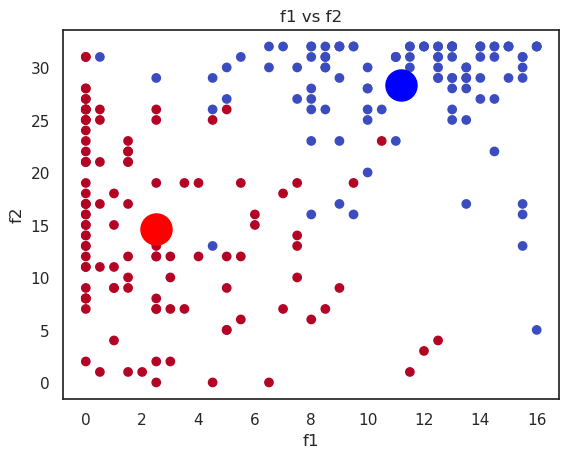

In [47]:
## TODO: add legend to plot

features = features2d(X_train)
print(features.shape)
## make a scatter plot of the features
plt.figure()
plt.scatter(features[:,0], features[:,1], c=~y_train, cmap="coolwarm")
## plot the mean of the classes
plt.scatter(np.mean(features[y_train == 3],axis=0)[0],np.mean(features[y_train == 3],axis=0)[1],c="red",marker="o",s=500)
plt.scatter(np.mean(features[y_train == 9],axis=0)[0],np.mean(features[y_train == 9],axis=0)[1],c="blue",marker="o",s=500)
## make legend for each class
plt.xlabel("f1")
plt.ylabel("f2")
plt.title("f1 vs f2")
plt.show()

In [48]:
from pprint import pprint
## NOTE: the error is not normalized
print("Note that error in not normalized")
predicted_test_labels = nearest_mean(features2d(X_train),transform_labels(y_train),features2d(X_test))
print("Testing error:",error(transform_labels(y_test),predicted_test_labels))

Note that error in not normalized
Training error:  0.10599078341013825
Testing error: 0.07534246575342465


Training error:  0.10599078341013825


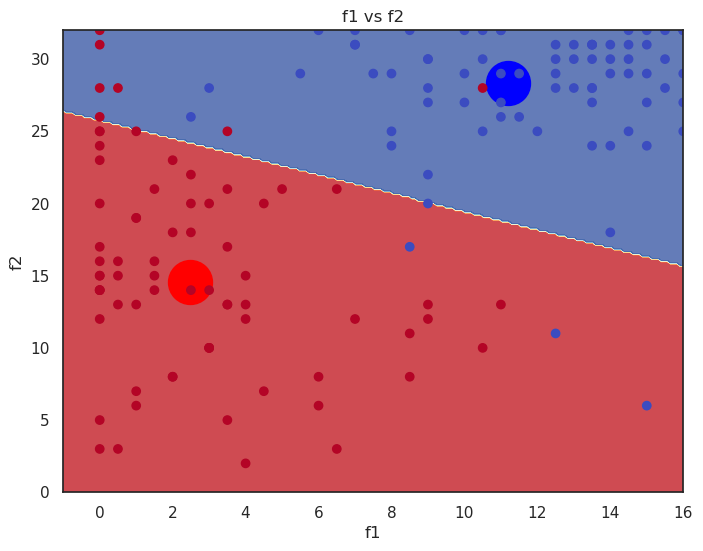

In [49]:
x_lim = 16
y_lim = 32

## TODO: either add transformation from feature space to grid space or play with limits

xx, yy = np.meshgrid(np.linspace(-1, x_lim, 200), np.linspace(0, y_lim, 200))
grid_features = np.c_[xx.ravel(), yy.ravel()]
grid_prediction = nearest_mean(features2d(X_train),transform_labels(y_train),grid_features)
grid_prediction = grid_prediction.reshape(xx.shape)

mean_3,mean_9 = get_clusters(features2d(X_train),transform_labels(y_train))

## create a transformation from the feature space to the grid space
# Plot the decision regions
plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, grid_prediction, cmap=plt.cm.RdYlBu, alpha=0.8)
plt.scatter(mean_3[0],mean_3[1],c="red",marker="o",s=1000)
plt.scatter(mean_9[0],mean_9[1],c="blue",marker="o",s=1000)
## plot test data
plt.scatter(features2d(X_test)[:,0], features2d(X_test)[:,1], c=~y_test, cmap="coolwarm")
plt.xlabel("f1")
plt.ylabel("f2")
plt.title("f1 vs f2")
plt.show()

### Task 3

In [50]:
def fit_lda(training_features,training_labels):
    N,D = training_features.shape

    idx_1 = training_labels == -1
    idx_2 = training_labels == 1

    priors = np.array([np.sum(idx_1)/N,np.sum(idx_2)/N])

    features_1 = training_features[idx_1]
    features_2 = training_features[idx_2]

    mean_1 = np.mean(features_1,axis=0)
    mean_2 = np.mean(features_2,axis=0)

    mu= np.column_stack((mean_1,mean_2))

    ## TODO: replace with linear form (matrix multiplication)
    acc_1 = np.zeros((D,D))
    for x_1 in features_1:
        x_1 = x_1 - mean_1
        acc_1 += x_1.reshape(-1,1) @ x_1.reshape(1,-1)

    acc_2 = np.zeros((D,D))
    for x_2 in features_2:
        x_2 = x_2 - mean_2
        acc_2 += x_2.reshape(-1,1) @ x_2.reshape(1,-1)

    covmat = (acc_1 + acc_2)/N

    return mu,covmat, priors

In [51]:
mu,covmat, priors = fit_lda(features2d(X_train),transform_labels(y_train))
pprint(mu)
pprint(covmat)
pprint(priors)

array([[ 2.47747748, 11.18867925],
       [14.58558559, 28.3490566 ]])
array([[10.23695903, -4.2857934 ],
       [-4.2857934 , 45.79272739]])
array([0.51152074, 0.48847926])


In [52]:
## filter low variance columns / pixels
columns_to_keep = np.var(X_train,axis=0) >= 0.001
filtered_features = X_train[:, columns_to_keep]
print(filtered_features.shape)

mu,covmat, priors = fit_lda(filtered_features,transform_labels(y_train))
pprint(mu.shape)
pprint(covmat.shape)
pprint(priors.shape)

(217, 53)
(53, 2)
(53, 53)
(2,)


In [53]:
def predict_lda(mu,covmat,p,test_features):
    '''
    mu[0] - label -1
    mu[1] - label 1

    p[0] - #-1 / total
    p[1] - # 1 / total
    '''
    # print(np.linalg.inv(covmat).shape)
    # print((mu[1] - mu[0]).T.shape)
    beta = np.linalg.inv(covmat) @ (mu[1] - mu[0]).T ## should be d x _
    beta = beta[:,np.newaxis]
    # print(beta.shape)
    b = -0.5 * (mu[0] + mu[1]).T @ beta + np.log(p[1] / p[0])

    y_hat = []

    for xi in test_features:
        y_hat.append(np.sign(xi @ beta + b))

    # y_hat = np.sign(test_features * beta + b)

    return np.array(y_hat)

In [54]:
mu, covmat, priors = fit_lda(features2d(X_train),transform_labels(y_train))
labels = predict_lda(mu,covmat,priors,features2d(X_test))
labels = labels.reshape(-1)
print("Test error: ",error(y_test,labels))

mu, covmat, priors = fit_lda(features2d(X_train),transform_labels(y_train))
labels = predict_lda(mu,covmat,priors,features2d(X_train))
labels = labels.reshape(-1)
print("Train error: ",error(y_train,labels))


Test error:  0.0273972602739726
Train error:  0.05069124423963134
